In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("mps")

In [4]:
import random
import numpy as np

# 랜덤 시드 고정 함수
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 시드 고정
    torch.mps.manual_seed(seed)
    np.random.seed(seed)     # NumPy 시드 고정
    random.seed(seed)        # Python random 시드 고정

# 시드 설정
SEED = 32
set_random_seed(SEED)

## [MY CODE] Dataset 및 activation 함수 변경 (1/2)

In [5]:
# 데이터셋 전처리
transform = transforms.Compose([
    transforms.ToTensor(),                # 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화: 평균 0.5, 표준편차 0.5로 이미지 값을 [-1, 1]로 스케일 조정
])

batch_size = 256

# CIFAR10 훈련 데이터셋 로드
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# CIFAR10 학습 데이터 로더
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# CIFAR10 테스트 데이터셋 로드
test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

# CIFAR10 테스트 데이터 로더
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## [MY CODE] CIFAR10의 입력 shape 확인

In [6]:
from matplotlib import pyplot as plt
import numpy as np

print(len(train_set))
print(type(train_set))
print(train_set.data.shape)
print(train_set[0][0].shape, train_set[0][1])
print(len(np.unique(train_set.targets)))

50000
<class 'torchvision.datasets.cifar.CIFAR10'>
(50000, 32, 32, 3)
torch.Size([3, 32, 32]) 6
10


In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


1. 이미지의 Shape: torch.Size([256, 3, 32, 32])
 - 256: 배치 크기(batch size). 한 번에 256개의 이미지를 가져옵니다.
 - 채널 수(channel). 이미지가 RGB 컬러 이미지이므로 3개의 채널이 있습니다.
 - 32: 이미지의 높이(height). 32픽셀입니다.
 - 32: 이미지의 너비(width). 32픽셀입니다.
images는 256개의 RGB 이미지로, 각 이미지의 크기는 32x32 픽셀입니다.

2. 레이블의 Shape: torch.Size([256])
 - 256: 배치 크기와 동일합니다.
 - 각 레이블은 해당 이미지의 클래스 인덱스(정수값)를 나타냅니다.




## [MY CODE] Dataset 및 activation 함수 변경 (2/2)

In [37]:
from torch import nn


class Model(nn.Module):
    def __init__(self, activation, input_dim, num_dim, num_classes):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = activation()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + Activation
        x = self.act(self.layer2(x))       # 두 번째 레이어 + Activation
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        return x

# [MY CODE] SGD와 Adam 성능 비교

In [8]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(title, train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.title(title)
  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

In [12]:
import torch.optim as optim

lr = 0.001
num_epochs = 50

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
leakyReLU_SGD_test_accuracies = []

# LeakyReLU + SGD

In [42]:
import time

model = Model(nn.LeakyReLU, 3 * 32 * 32, 512, 10)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  leakyReLU_SGD_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 3.63 seconds | Loss: 2.29 | Train Acc: 0.152 | Test Acc: 0.152
Epoch   2 | Time: 3.80 seconds | Loss: 2.28 | Train Acc: 0.195 | Test Acc: 0.195
Epoch   3 | Time: 3.65 seconds | Loss: 2.26 | Train Acc: 0.222 | Test Acc: 0.224
Epoch   4 | Time: 3.59 seconds | Loss: 2.24 | Train Acc: 0.238 | Test Acc: 0.241
Epoch   5 | Time: 3.63 seconds | Loss: 2.23 | Train Acc: 0.249 | Test Acc: 0.254
Epoch   6 | Time: 3.60 seconds | Loss: 2.21 | Train Acc: 0.255 | Test Acc: 0.260
Epoch   7 | Time: 3.56 seconds | Loss: 2.19 | Train Acc: 0.260 | Test Acc: 0.264
Epoch   8 | Time: 3.61 seconds | Loss: 2.17 | Train Acc: 0.262 | Test Acc: 0.266
Epoch   9 | Time: 3.62 seconds | Loss: 2.15 | Train Acc: 0.265 | Test Acc: 0.269
Epoch  10 | Time: 3.60 seconds | Loss: 2.14 | Train Acc: 0.269 | Test Acc: 0.272
Epoch  11 | Time: 3.59 seconds | Loss: 2.12 | Train Acc: 0.272 | Test Acc: 0.275
Epoch  12 | Time: 3.76 seconds | Loss: 2.10 | Train Acc: 0.276 | Test Acc: 0.278
Epoch  13 | Time: 3.52 secon

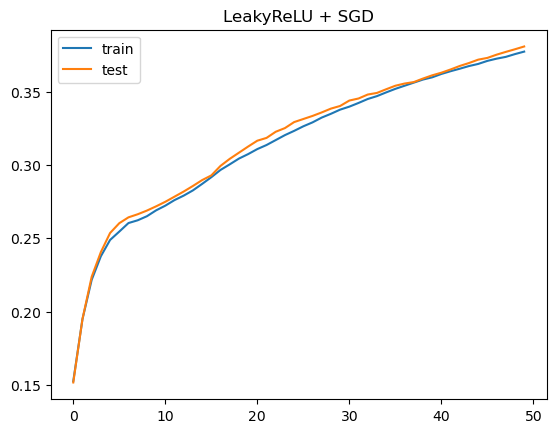

In [43]:
plot_acc('LeakyReLU + SGD', train_accuracies, leakyReLU_SGD_test_accuracies)

# LeakyReLU + Adam

In [44]:
model = Model(nn.LeakyReLU, 3 * 32 * 32, 512, 10)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
leakyReLU_adam_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  leakyReLU_adam_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 3.72 seconds | Loss: 1.64 | Train Acc: 0.500 | Test Acc: 0.482
Epoch   2 | Time: 3.79 seconds | Loss: 1.41 | Train Acc: 0.547 | Test Acc: 0.506
Epoch   3 | Time: 3.88 seconds | Loss: 1.29 | Train Acc: 0.589 | Test Acc: 0.524
Epoch   4 | Time: 3.72 seconds | Loss: 1.19 | Train Acc: 0.635 | Test Acc: 0.530
Epoch   5 | Time: 3.74 seconds | Loss: 1.09 | Train Acc: 0.667 | Test Acc: 0.548
Epoch   6 | Time: 3.72 seconds | Loss: 1.00 | Train Acc: 0.693 | Test Acc: 0.537
Epoch   7 | Time: 3.77 seconds | Loss: 0.91 | Train Acc: 0.732 | Test Acc: 0.545
Epoch   8 | Time: 3.79 seconds | Loss: 0.82 | Train Acc: 0.767 | Test Acc: 0.545
Epoch   9 | Time: 3.81 seconds | Loss: 0.73 | Train Acc: 0.792 | Test Acc: 0.549
Epoch  10 | Time: 3.73 seconds | Loss: 0.64 | Train Acc: 0.822 | Test Acc: 0.537
Epoch  11 | Time: 3.84 seconds | Loss: 0.56 | Train Acc: 0.849 | Test Acc: 0.536
Epoch  12 | Time: 3.73 seconds | Loss: 0.48 | Train Acc: 0.878 | Test Acc: 0.551
Epoch  13 | Time: 3.73 secon

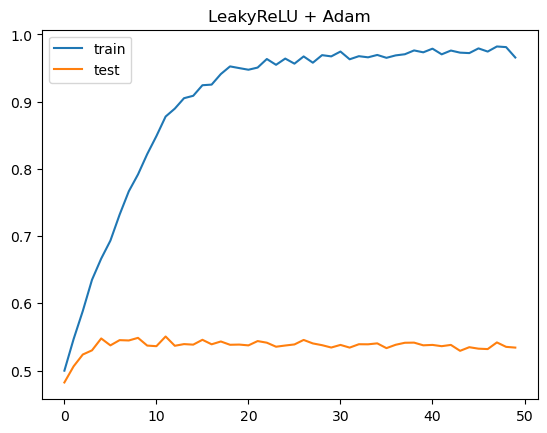

In [45]:
plot_acc('LeakyReLU + Adam', train_accuracies, leakyReLU_adam_test_accuracies)

# [MY CODE] Leaky ReLU와 Sigmoid 성능 비교

# Sigmoid + Adam

In [46]:
model = Model(nn.Sigmoid, 3 * 32 * 32, 512, 10)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
sigmoid_adam_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  sigmoid_adam_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 3.76 seconds | Loss: 1.81 | Train Acc: 0.423 | Test Acc: 0.417
Epoch   2 | Time: 3.77 seconds | Loss: 1.60 | Train Acc: 0.467 | Test Acc: 0.450
Epoch   3 | Time: 3.71 seconds | Loss: 1.49 | Train Acc: 0.506 | Test Acc: 0.474
Epoch   4 | Time: 3.72 seconds | Loss: 1.40 | Train Acc: 0.526 | Test Acc: 0.482
Epoch   5 | Time: 3.70 seconds | Loss: 1.33 | Train Acc: 0.563 | Test Acc: 0.501
Epoch   6 | Time: 3.70 seconds | Loss: 1.25 | Train Acc: 0.590 | Test Acc: 0.506
Epoch   7 | Time: 3.70 seconds | Loss: 1.18 | Train Acc: 0.618 | Test Acc: 0.502
Epoch   8 | Time: 3.70 seconds | Loss: 1.11 | Train Acc: 0.655 | Test Acc: 0.510
Epoch   9 | Time: 3.71 seconds | Loss: 1.04 | Train Acc: 0.678 | Test Acc: 0.512
Epoch  10 | Time: 3.78 seconds | Loss: 0.96 | Train Acc: 0.707 | Test Acc: 0.511
Epoch  11 | Time: 3.70 seconds | Loss: 0.90 | Train Acc: 0.735 | Test Acc: 0.509
Epoch  12 | Time: 3.73 seconds | Loss: 0.83 | Train Acc: 0.756 | Test Acc: 0.506
Epoch  13 | Time: 3.73 secon

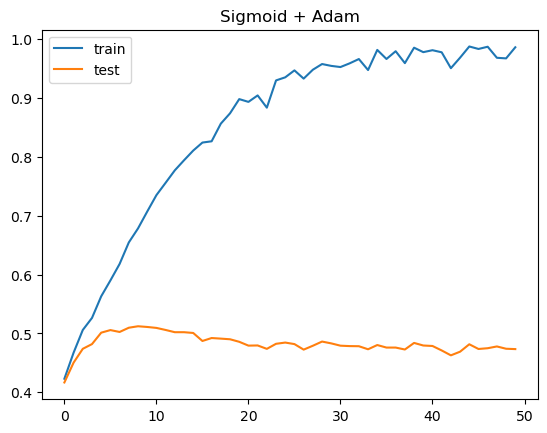

In [47]:
plot_acc('Sigmoid + Adam', train_accuracies, sigmoid_adam_test_accuracies)

## [MY CODE] Dropout을 적용한 이후의 generalization error 확인

In [48]:
class ModelWithDrop(nn.Module):
    def __init__(self, activation, input_dim, num_dim, num_classes, dropout_prob):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = activation()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 레이어

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + Activation
        x = self.dropout(x)
        x = self.act(self.layer2(x))       # 두 번째 레이어 + Activation
        x = self.dropout(x)
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        return x

# LeakyReLU + Adam + Dropout

In [49]:
model = ModelWithDrop(nn.LeakyReLU, 3 * 32 * 32, 512, 10, 0.1)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
leakyReLU_adam_dropout_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  leakyReLU_adam_dropout_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 4.05 seconds | Loss: 1.66 | Train Acc: 0.485 | Test Acc: 0.472
Epoch   2 | Time: 3.82 seconds | Loss: 1.45 | Train Acc: 0.539 | Test Acc: 0.508
Epoch   3 | Time: 3.78 seconds | Loss: 1.34 | Train Acc: 0.573 | Test Acc: 0.515
Epoch   4 | Time: 3.79 seconds | Loss: 1.26 | Train Acc: 0.605 | Test Acc: 0.526
Epoch   5 | Time: 3.80 seconds | Loss: 1.19 | Train Acc: 0.624 | Test Acc: 0.529
Epoch   6 | Time: 3.81 seconds | Loss: 1.12 | Train Acc: 0.657 | Test Acc: 0.540
Epoch   7 | Time: 3.79 seconds | Loss: 1.06 | Train Acc: 0.685 | Test Acc: 0.549
Epoch   8 | Time: 3.80 seconds | Loss: 0.99 | Train Acc: 0.717 | Test Acc: 0.551
Epoch   9 | Time: 3.89 seconds | Loss: 0.93 | Train Acc: 0.737 | Test Acc: 0.553
Epoch  10 | Time: 3.80 seconds | Loss: 0.87 | Train Acc: 0.763 | Test Acc: 0.553
Epoch  11 | Time: 3.78 seconds | Loss: 0.82 | Train Acc: 0.780 | Test Acc: 0.553
Epoch  12 | Time: 3.78 seconds | Loss: 0.77 | Train Acc: 0.810 | Test Acc: 0.554
Epoch  13 | Time: 3.79 secon

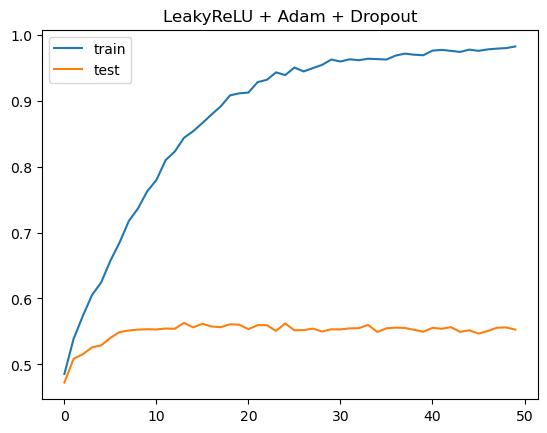

In [50]:
plot_acc('LeakyReLU + Adam + Dropout', train_accuracies, leakyReLU_adam_dropout_test_accuracies)

In [51]:
# 전체 비교

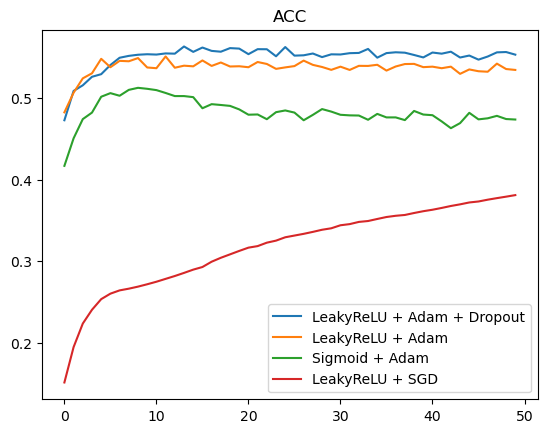

In [56]:
plt.title('ACC')
x = np.arange(50)
plt.plot(x, leakyReLU_adam_dropout_test_accuracies, label='LeakyReLU + Adam + Dropout')
plt.plot(x, leakyReLU_adam_test_accuracies, label='LeakyReLU + Adam')
plt.plot(x, sigmoid_adam_test_accuracies, label='Sigmoid + Adam')
plt.plot(x, leakyReLU_SGD_test_accuracies, label='LeakyReLU + SGD')
plt.legend()
plt.show()

과제와 상관없이 개인적으로 CNN 결과가 궁금

# CNN 테스트 (No Dropout)
활성화: LeakyReLU
손실: CrossEntropyLoss
옵티마이저: Adam

In [ ]:
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 입력 채널 3
        self.pool = nn.MaxPool2d(2, 2)               # 풀링 크기 2x2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 출력 채널 64
        self.fc1 = nn.Linear(64 * 8 * 8, 512)        # 완전 연결 층
        self.fc2 = nn.Linear(512, 10)                # 출력 층 (10개의 클래스)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # 플래튼
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
import time

model = SimpleCNN()
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
cnn_leakyReLU_adam_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  cnn_leakyReLU_adam_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 13.65 seconds | Loss: 1.45 | Train Acc: 0.582 | Test Acc: 0.573
Epoch   2 | Time: 19.74 seconds | Loss: 1.07 | Train Acc: 0.677 | Test Acc: 0.650
Epoch   3 | Time: 9.36 seconds | Loss: 0.91 | Train Acc: 0.715 | Test Acc: 0.670
Epoch   4 | Time: 17.93 seconds | Loss: 0.79 | Train Acc: 0.763 | Test Acc: 0.700
Epoch   5 | Time: 10.67 seconds | Loss: 0.67 | Train Acc: 0.798 | Test Acc: 0.709
Epoch   6 | Time: 19.74 seconds | Loss: 0.58 | Train Acc: 0.839 | Test Acc: 0.720
Epoch   7 | Time: 9.48 seconds | Loss: 0.47 | Train Acc: 0.883 | Test Acc: 0.729
Epoch   8 | Time: 9.30 seconds | Loss: 0.37 | Train Acc: 0.922 | Test Acc: 0.732
Epoch   9 | Time: 8.30 seconds | Loss: 0.27 | Train Acc: 0.953 | Test Acc: 0.738
Epoch  10 | Time: 8.28 seconds | Loss: 0.19 | Train Acc: 0.971 | Test Acc: 0.734
Epoch  11 | Time: 8.25 seconds | Loss: 0.12 | Train Acc: 0.985 | Test Acc: 0.733
Epoch  12 | Time: 8.22 seconds | Loss: 0.07 | Train Acc: 0.992 | Test Acc: 0.734
Epoch  13 | Time: 8.22 

# CNN 테스트 (With Dropout(p=0.1))
활성화: LeakyReLU
손실: CrossEntropyLoss
옵티마이저: Adam

In [0]:
from torch import nn

class SimpleCNNWithDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 입력 채널 3
        self.pool = nn.MaxPool2d(2, 2)               # 풀링 크기 2x2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 출력 채널 64
        self.fc1 = nn.Linear(64 * 8 * 8, 512)        # 완전 연결 층
        self.fc2 = nn.Linear(512, 10)                # 출력 층 (10개의 클래스)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # 플래튼
        x = self.act(self.fc1(x))
        x = self.dropout(x)  # Dropout 적용
        x = self.fc2(x)
        return x


In [22]:
model = SimpleCNN()
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
cnn_leakyReLU_adam_dropout_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  cnn_leakyReLU_adam_dropout_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 8.27 seconds | Loss: 1.42 | Train Acc: 0.585 | Test Acc: 0.575
Epoch   2 | Time: 8.22 seconds | Loss: 1.05 | Train Acc: 0.676 | Test Acc: 0.648
Epoch   3 | Time: 8.23 seconds | Loss: 0.88 | Train Acc: 0.731 | Test Acc: 0.683
Epoch   4 | Time: 8.22 seconds | Loss: 0.76 | Train Acc: 0.786 | Test Acc: 0.709
Epoch   5 | Time: 8.27 seconds | Loss: 0.65 | Train Acc: 0.824 | Test Acc: 0.718
Epoch   6 | Time: 8.22 seconds | Loss: 0.55 | Train Acc: 0.859 | Test Acc: 0.728
Epoch   7 | Time: 8.26 seconds | Loss: 0.44 | Train Acc: 0.869 | Test Acc: 0.713
Epoch   8 | Time: 8.24 seconds | Loss: 0.34 | Train Acc: 0.930 | Test Acc: 0.734
Epoch   9 | Time: 8.27 seconds | Loss: 0.24 | Train Acc: 0.964 | Test Acc: 0.733
Epoch  10 | Time: 8.24 seconds | Loss: 0.17 | Train Acc: 0.970 | Test Acc: 0.730
Epoch  11 | Time: 8.25 seconds | Loss: 0.11 | Train Acc: 0.987 | Test Acc: 0.731
Epoch  12 | Time: 8.22 seconds | Loss: 0.06 | Train Acc: 0.986 | Test Acc: 0.727
Epoch  13 | Time: 8.26 secon

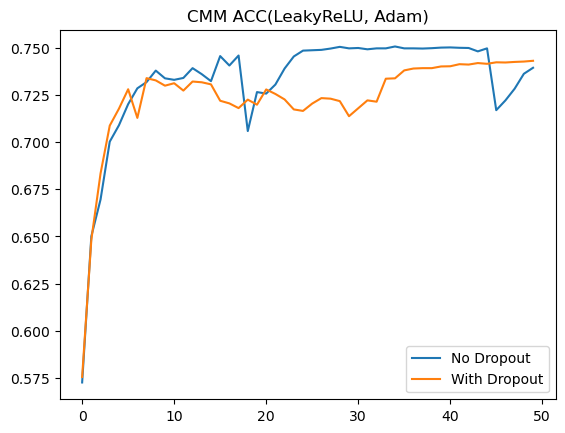

In [23]:
plt.title('CNN ACC')
x = np.arange(50)
plt.plot(x, cnn_leakyReLU_adam_test_accuracies, label='No Dropout')
plt.plot(x, cnn_leakyReLU_adam_dropout_test_accuracies, label='With Dropout(p=0.1)')
plt.legend()
plt.show()

# ImprovedCNN
더 깊은 네트워크
드롭아웃 비율 0.5
(데이터 증강은 나중에!)

In [24]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # 입력 채널 3 -> 출력 채널 64
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # 출력 채널 128
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # 출력 채널 256
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 맥스 풀링
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 확률 0.5
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # FC 레이어 1
        self.fc2 = nn.Linear(1024, 10)  # FC 레이어 2 (10 클래스)
        self.act = nn.ReLU()

    def forward(self, x):
        # Conv 레이어 + ReLU + MaxPooling
        x = self.pool(self.act(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(self.act(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        x = self.pool(self.act(self.conv3(x)))  # Conv3 -> ReLU -> Pooling

        # Flatten
        x = x.view(-1, 256 * 4 * 4)

        # FC 레이어 + ReLU + Dropout
        x = self.act(self.fc1(x))  # Fully Connected -> ReLU
        x = self.dropout(x)      # Dropout

        # 출력 레이어
        x = self.fc2(x)          # Final output layer
        return x

In [26]:
model = ImprovedCNN()
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
super_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  super_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 20.94 seconds | Loss: 1.51 | Train Acc: 0.586 | Test Acc: 0.574
Epoch   2 | Time: 18.47 seconds | Loss: 1.04 | Train Acc: 0.707 | Test Acc: 0.678
Epoch   3 | Time: 18.38 seconds | Loss: 0.83 | Train Acc: 0.767 | Test Acc: 0.722
Epoch   4 | Time: 18.32 seconds | Loss: 0.70 | Train Acc: 0.802 | Test Acc: 0.740
Epoch   5 | Time: 18.45 seconds | Loss: 0.59 | Train Acc: 0.831 | Test Acc: 0.749
Epoch   6 | Time: 18.33 seconds | Loss: 0.50 | Train Acc: 0.886 | Test Acc: 0.775
Epoch   7 | Time: 18.47 seconds | Loss: 0.42 | Train Acc: 0.907 | Test Acc: 0.776
Epoch   8 | Time: 18.48 seconds | Loss: 0.34 | Train Acc: 0.939 | Test Acc: 0.783
Epoch   9 | Time: 18.49 seconds | Loss: 0.28 | Train Acc: 0.953 | Test Acc: 0.786
Epoch  10 | Time: 18.38 seconds | Loss: 0.23 | Train Acc: 0.972 | Test Acc: 0.783
Epoch  11 | Time: 18.39 seconds | Loss: 0.18 | Train Acc: 0.978 | Test Acc: 0.790
Epoch  12 | Time: 18.47 seconds | Loss: 0.15 | Train Acc: 0.985 | Test Acc: 0.787
Epoch  13 | Time

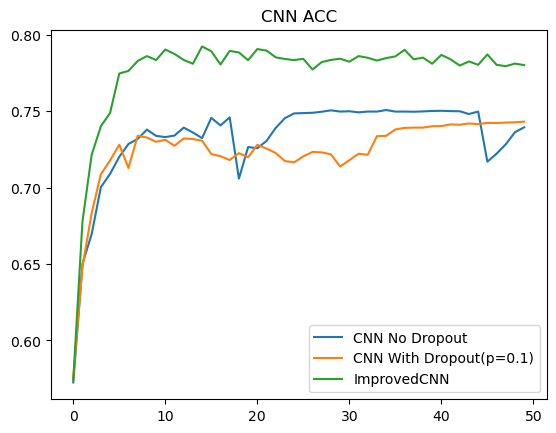

In [27]:
plt.title('CNN ACC')
x = np.arange(50)
plt.plot(x, cnn_leakyReLU_adam_test_accuracies, label='CNN No Dropout')
plt.plot(x, cnn_leakyReLU_adam_dropout_test_accuracies, label='CNN With Dropout(p=0.1)')
plt.plot(x, super_test_accuracies, label='ImprovedCNN')
plt.legend()
plt.show()

# 데이터 증강

In [42]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 훈련 데이터셋 로드
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train,
)

# CIFAR10 학습 데이터 로더
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

Files already downloaded and verified


In [43]:
class ImprovedCNN2(nn.Module):
    def __init__(self):
        super(ImprovedCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # 입력 채널 3 -> 출력 채널 64
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # 출력 채널 128
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # 출력 채널 256
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 맥스 풀링
        self.dropout = nn.Dropout(0.3)  # 데이터 증강을 했으니 Dropout 비율을 줄여본다.
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # FC 레이어 1
        self.fc2 = nn.Linear(1024, 10)  # FC 레이어 2 (10 클래스)
        self.act = nn.ReLU()

    def forward(self, x):
        # Conv 레이어 + ReLU + MaxPooling
        x = self.pool(self.act(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(self.act(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        x = self.pool(self.act(self.conv3(x)))  # Conv3 -> ReLU -> Pooling

        # Flatten
        x = x.view(-1, 256 * 4 * 4)

        # FC 레이어 + ReLU + Dropout
        x = self.act(self.fc1(x))  # Fully Connected -> ReLU
        x = self.dropout(x)      # Dropout

        # 출력 레이어
        x = self.fc2(x)          # Final output layer
        return x

In [44]:
model = ImprovedCNN2()
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
augmentation_super_test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  augmentation_super_test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 20.25 seconds | Loss: 1.56 | Train Acc: 0.541 | Test Acc: 0.556
Epoch   2 | Time: 20.22 seconds | Loss: 1.15 | Train Acc: 0.641 | Test Acc: 0.648
Epoch   3 | Time: 20.20 seconds | Loss: 0.95 | Train Acc: 0.708 | Test Acc: 0.706
Epoch   4 | Time: 20.17 seconds | Loss: 0.82 | Train Acc: 0.746 | Test Acc: 0.737
Epoch   5 | Time: 20.18 seconds | Loss: 0.75 | Train Acc: 0.769 | Test Acc: 0.758
Epoch   6 | Time: 20.21 seconds | Loss: 0.68 | Train Acc: 0.773 | Test Acc: 0.761
Epoch   7 | Time: 20.18 seconds | Loss: 0.63 | Train Acc: 0.802 | Test Acc: 0.779
Epoch   8 | Time: 20.27 seconds | Loss: 0.58 | Train Acc: 0.826 | Test Acc: 0.797
Epoch   9 | Time: 20.27 seconds | Loss: 0.55 | Train Acc: 0.831 | Test Acc: 0.799
Epoch  10 | Time: 20.20 seconds | Loss: 0.51 | Train Acc: 0.836 | Test Acc: 0.803
Epoch  11 | Time: 20.24 seconds | Loss: 0.49 | Train Acc: 0.854 | Test Acc: 0.808
Epoch  12 | Time: 20.28 seconds | Loss: 0.46 | Train Acc: 0.860 | Test Acc: 0.818
Epoch  13 | Time

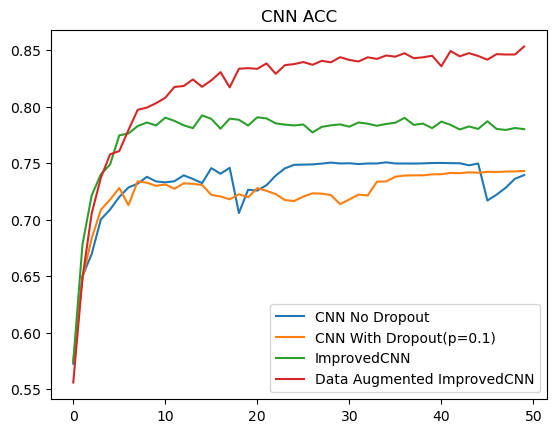

In [45]:
plt.title('CNN ACC')
x = np.arange(50)
plt.plot(x, cnn_leakyReLU_adam_test_accuracies, label='CNN No Dropout')
plt.plot(x, cnn_leakyReLU_adam_dropout_test_accuracies, label='CNN With Dropout(p=0.1)')
plt.plot(x, super_test_accuracies, label='ImprovedCNN')
plt.plot(x, augmentation_super_test_accuracies, label='Data Augmented + ImprovedCNN')
plt.legend()
plt.show()